<a href="https://colab.research.google.com/github/priyarameshd/Forecasting/blob/main/Forecasting_exchangerate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [96]:
series = read_csv('exchange_rate.csv', parse_dates=True,header=0)

### EDA

In [97]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [98]:
series.head(10)

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849
5,06-01-1990 00:00,0.7866
6,07-01-1990 00:00,0.7886
7,08-01-1990 00:00,0.7910
8,09-01-1990 00:00,0.7939
9,10-01-1990 00:00,0.7894


In [99]:
series['date'] = pd.to_datetime(series['date'],format='%d-%m-%Y %H:%M')

In [100]:
series = series.set_index('date')

In [101]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


### Visualization

<Axes: xlabel='Ex_rate'>

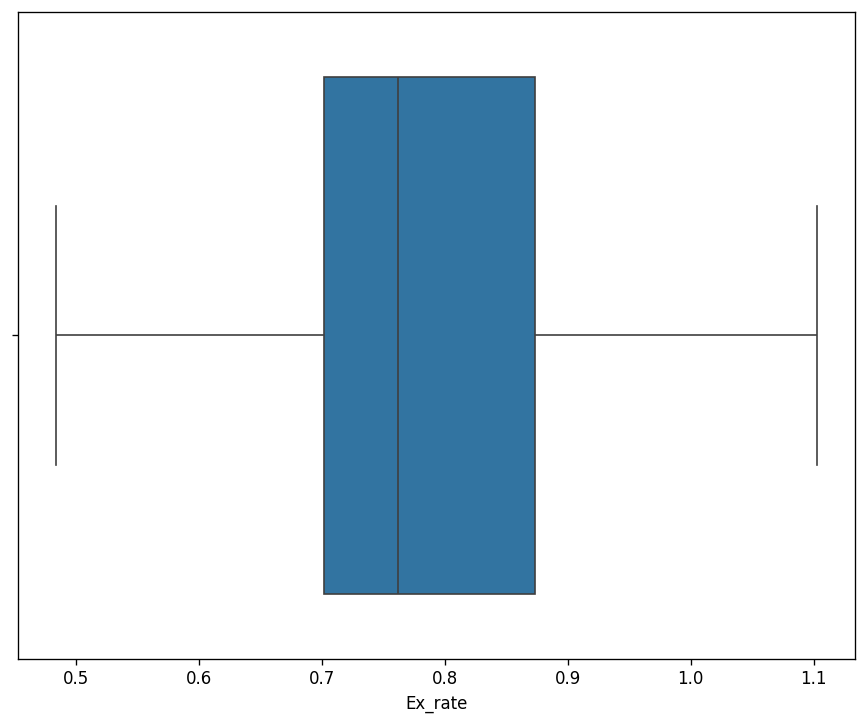

In [102]:
import seaborn as sns
sns.boxplot(x= series ['Ex_rate'])

No outliers.

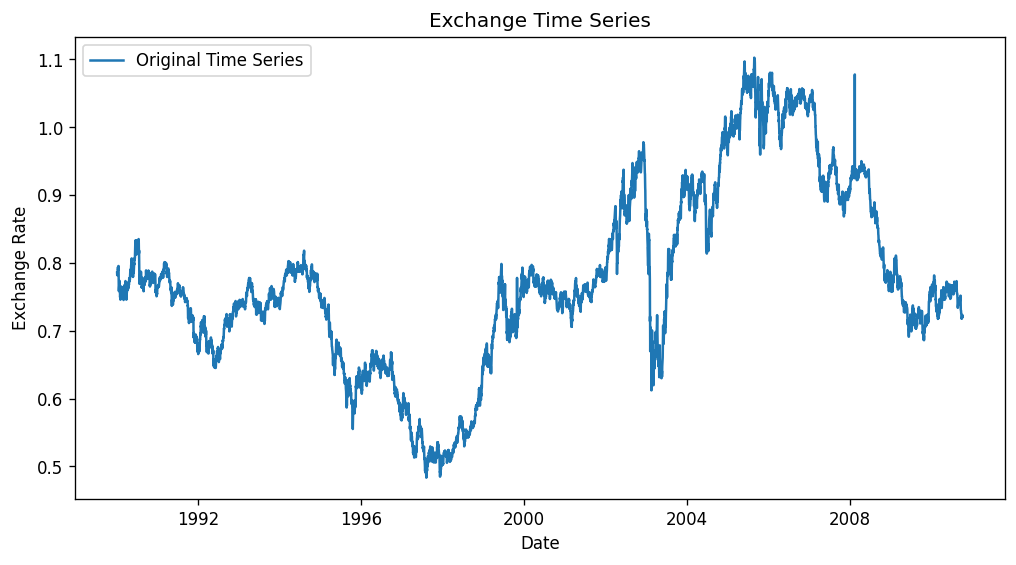

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(series, label='Original Time Series')
plt.title('Exchange Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

array([[<Axes: title={'center': 'Ex_rate'}>]], dtype=object)

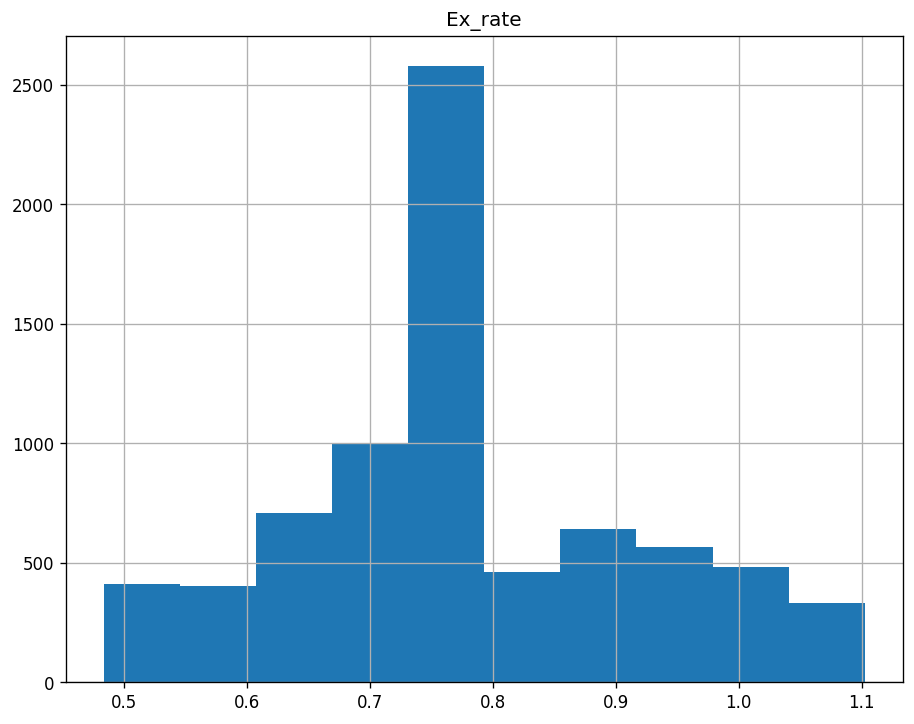

In [104]:
series.hist()

<Axes: ylabel='Density'>

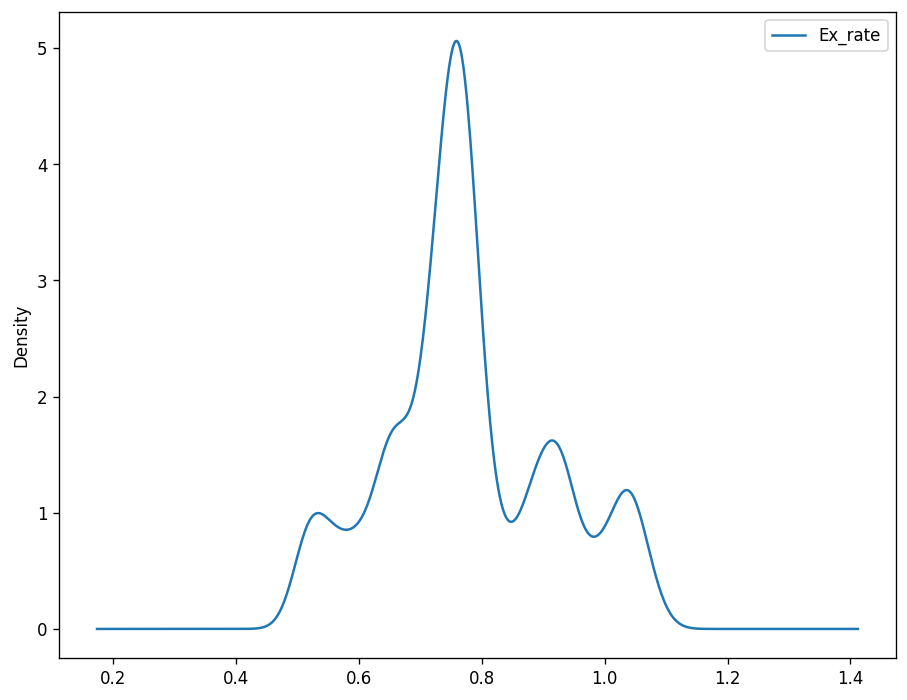

In [105]:
series.plot(kind='kde')

### Model Building ARIMA

### Decompose Time Series

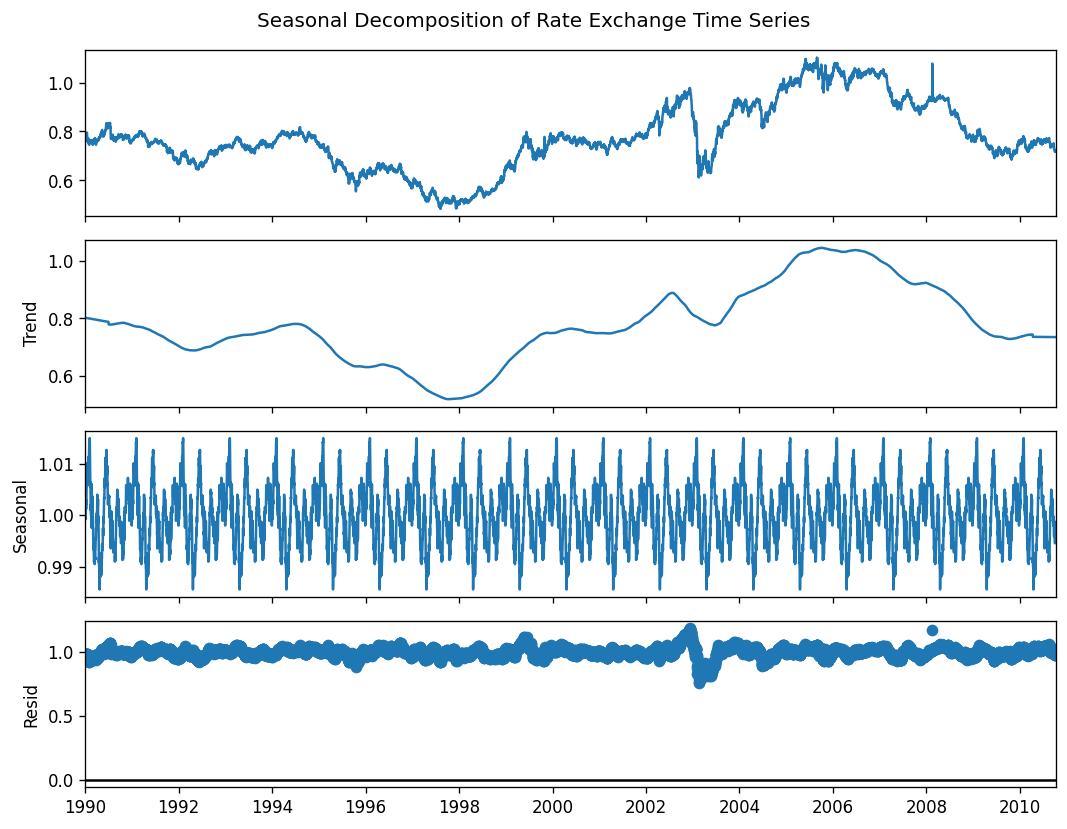

In [106]:
# Decompose the time series into trend, seasonal and residual components
#Seasonal_decompose tells us how our dataset looks in terms of trend, seasonal and residual.

result_decompose = seasonal_decompose(series, model='multiplicative', extrapolate_trend='freq',period=365)
result_decompose.plot()
plt.suptitle('Seasonal Decomposition of Rate Exchange Time Series')
plt.tight_layout()
plt.show()

Looks like non stationary data. For a more accurate assessment use Dickey-Fuller test.

In [107]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(series['Ex_rate'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.664994
p-value: 0.449233


A p-value below 0.05 indicates stationarity, and here it is 0.4 which is above 0.05, so we need to difference it.

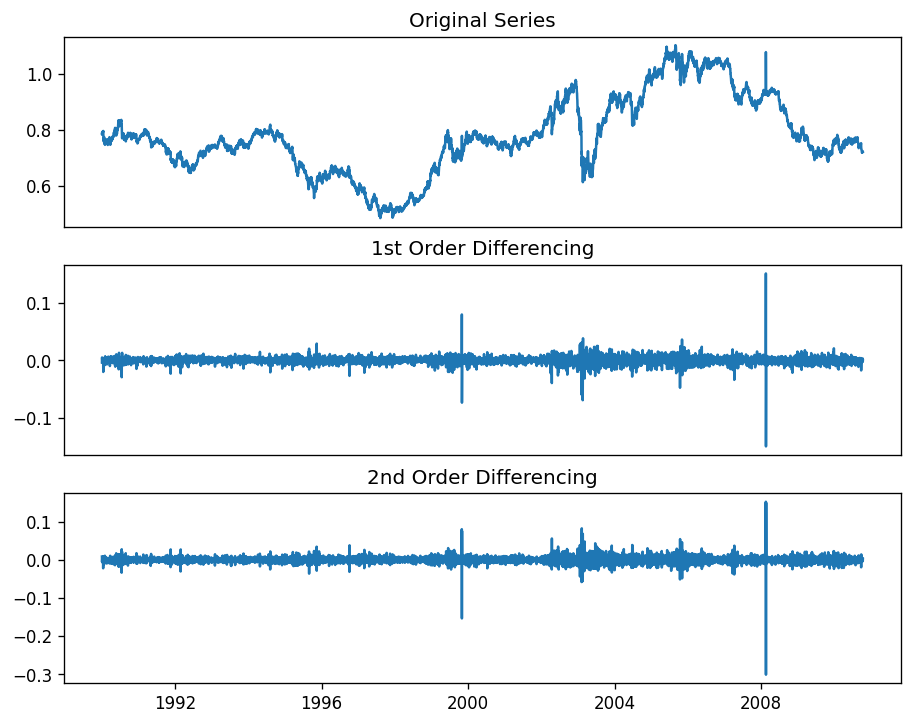

In [108]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(series.Ex_rate); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(series.Ex_rate.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(series.Ex_rate.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()


In [109]:
adf_test = adfuller(series['Ex_rate'].diff().dropna())
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -99.393431
p-value: 0.000000


Considering first order differencing as there is no numch difference in 1st order and 2nd order. After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

### ACF and PACF

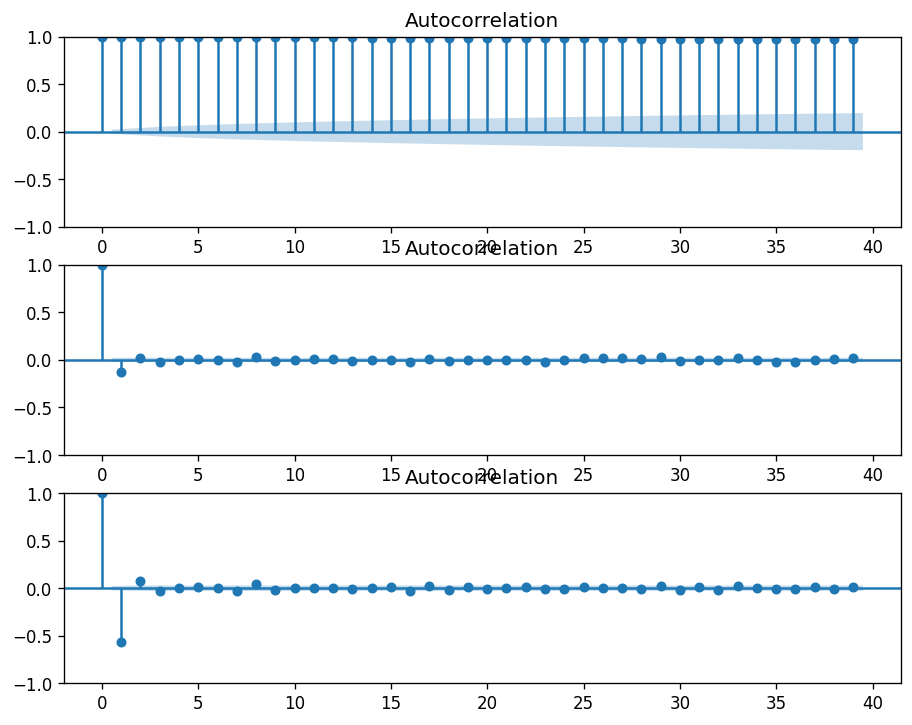

In [110]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(series.Ex_rate, ax=ax1)
plot_acf(series.Ex_rate.diff().dropna(), ax=ax2)
plot_acf(series.Ex_rate.diff().diff().dropna(), ax=ax3)
plt.show()

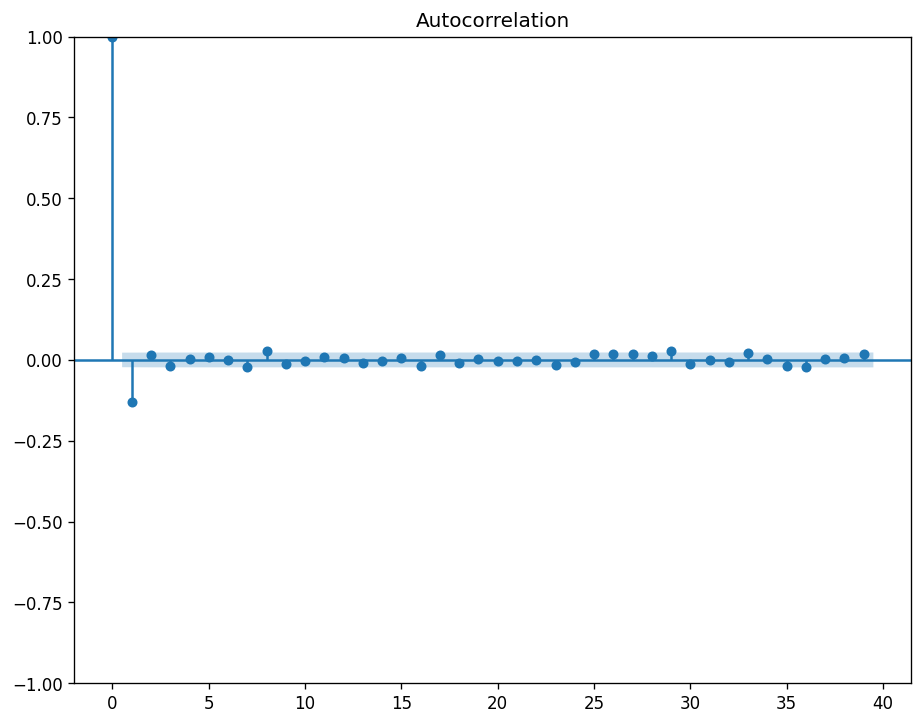

In [111]:
plot_acf(series.Ex_rate.diff().dropna())
plt.show()

In [112]:
# Perform Augmented Dickey-Fuller test
result = adfuller(series.Ex_rate.diff().dropna())

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

# Interpret the results
if p_value < 0.05:
    print('p-value is less than 0.05. Reject the null hypothesis.')
    print('The data is likely stationary.')
else:
    print('p-value is greater than or equal to 0.05. Fail to reject the null hypothesis.')
    print('The data is likely non-stationary.')

ADF Statistic: -99.39343120118632
p-value: 0.0
p-value is less than 0.05. Reject the null hypothesis.
The data is likely stationary.


** How to determin p, d, q**

It's easy to determin I. In this case,the first order differencing make the data stationary. So I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 2 lags the AR is significant. Which means, we can use AR = 2.

Taking MA as 0.


In [113]:
series_diff = series.Ex_rate.diff().dropna()

In [114]:
import statsmodels.tsa.arima.model as smt
model = smt.ARIMA(series, order = (2,1,0))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 0)   Log Likelihood               28054.161
Date:                Thu, 09 May 2024   AIC                         -56102.321
Time:                        13:11:32   BIC                         -56081.518
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.217      0.000      -0.135      -0.127
ar.L2         -0.0005      0.006     -0.089      0.929      -0.012       0.011
sigma2      3.595e-05   9.94e-08    361.615      0.000    3.58e-05    3.61e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865119.97
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
model = smt.ARIMA(series, order = (0,1,0))
model_fit1 = model.fit()
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(0, 1, 0)   Log Likelihood               27988.098
Date:                Thu, 09 May 2024   AIC                         -55974.195
Time:                        13:11:32   BIC                         -55967.261
Sample:                    01-01-1990   HQIC                        -55971.816
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.658e-05   7.77e-08    470.596      0.000    3.64e-05    3.67e-05
===================================================================================
Ljung-Box (L1) (Q):                 131.05   Jarque-Bera (JB):           4161024.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                       117.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

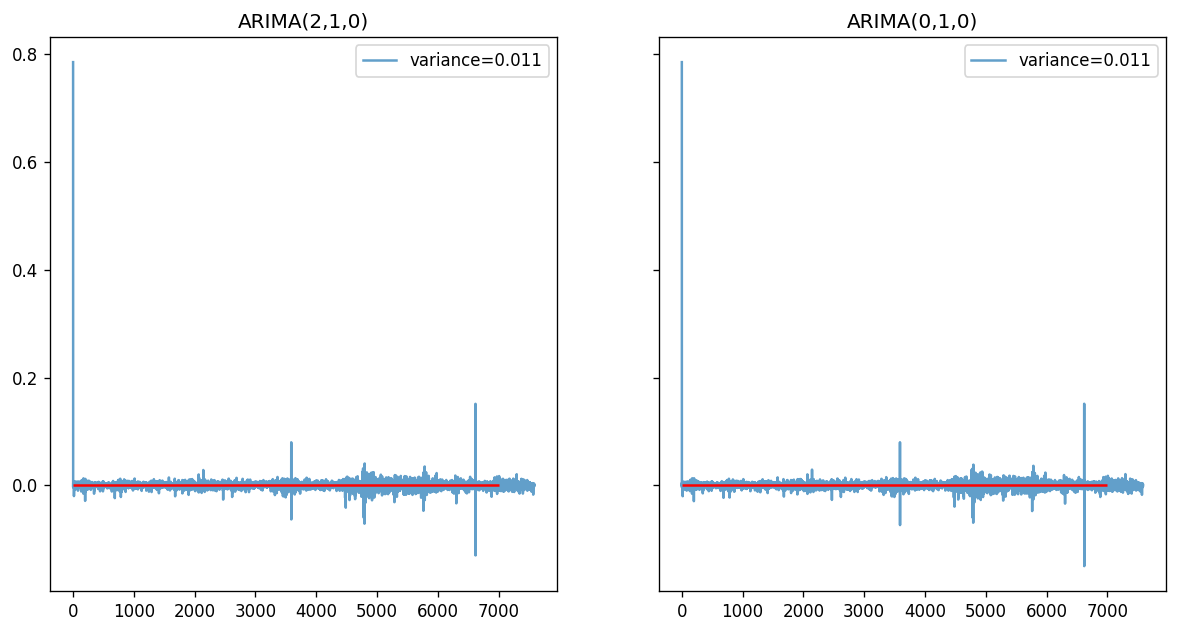

In [116]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(model_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(model_fit.resid.values)));
ax[0].hlines(0, xmin=0, xmax=7000, color='r');
ax[0].set_title("ARIMA(2,1,0)");
ax[0].legend();
ax[1].plot(model_fit1.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(model_fit1.resid.values)));
ax[1].hlines(0, xmin=0, xmax=7000, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

variance is same so any order is fine.

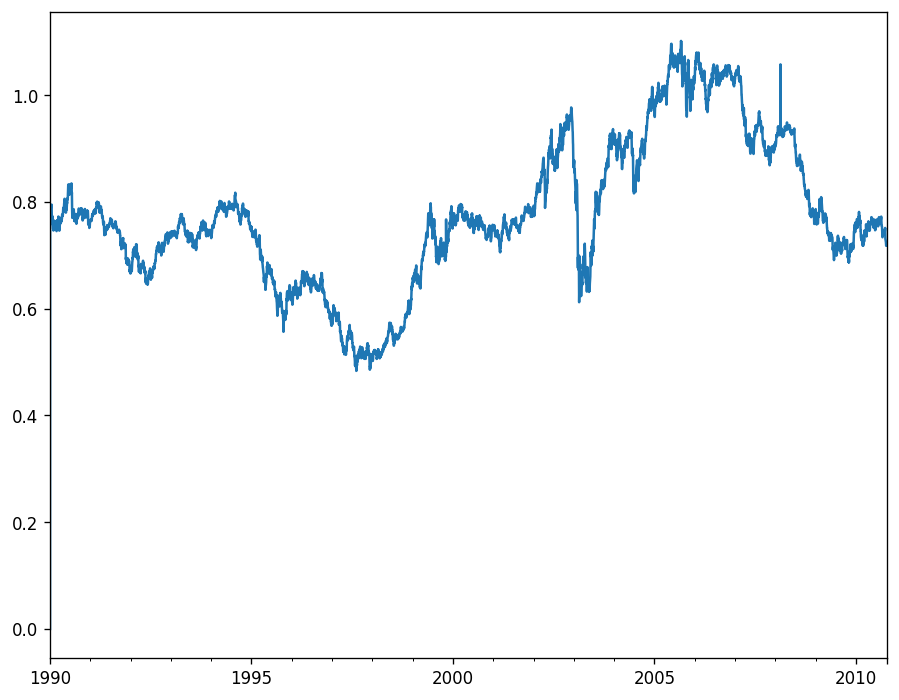

In [117]:
p = model_fit.predict()
p.plot()
plt.show()

### Finding ARIMA Parameters

In [118]:
# separate out a validation dataset


split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 7578, Validation 10


In [119]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)
train = train.squeeze()
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [120]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=0.761, Expected=0.757
>Predicted=0.757, Expected=0.757
>Predicted=0.757, Expected=0.758
>Predicted=0.758, Expected=0.758
>Predicted=0.758, Expected=0.755
>Predicted=0.755, Expected=0.755
>Predicted=0.755, Expected=0.756
>Predicted=0.756, Expected=0.759
>Predicted=0.759, Expected=0.762
>Predicted=0.762, Expected=0.763
>Predicted=0.763, Expected=0.760
>Predicted=0.760, Expected=0.761
>Predicted=0.761, Expected=0.763
>Predicted=0.763, Expected=0.763
>Predicted=0.763, Expected=0.761
>Predicted=0.761, Expected=0.758
>Predicted=0.758, Expected=0.751
>Predicted=0.751, Expected=0.755
>Predicted=0.755, Expected=0.757
>Predicted=0.757, Expected=0.755
>Predicted=0.755, Expected=0.755
>Predicted=0.755, Expected=0.766
>Predicted=0.766, Expected=0.768
>Predicted=0.768, Expected=0.770
>Predicted=0.770, Expected=0.767
>Predicted=0.767, Expected=0.762
>Predicted=0.762, Expected=0.761
>Predicted=0.761, Expected=0.761
>Predicted=0.761, Expected=0.765
>Predicted=0.765, Expected=0.767
>Predicted

In [121]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [122]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score = rmse
                        best_cfg = order
                    print('ARIMA %s RMSE = %.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA %s RMSE=%.3f' % (best_cfg, best_score))

In [123]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)

train = train.squeeze()
# evaluate parameters
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

Best ARIMA None RMSE=inf


None of the order iss best.

### Forecasting and evaluate model

In [124]:
import statsmodels.api as sm

# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

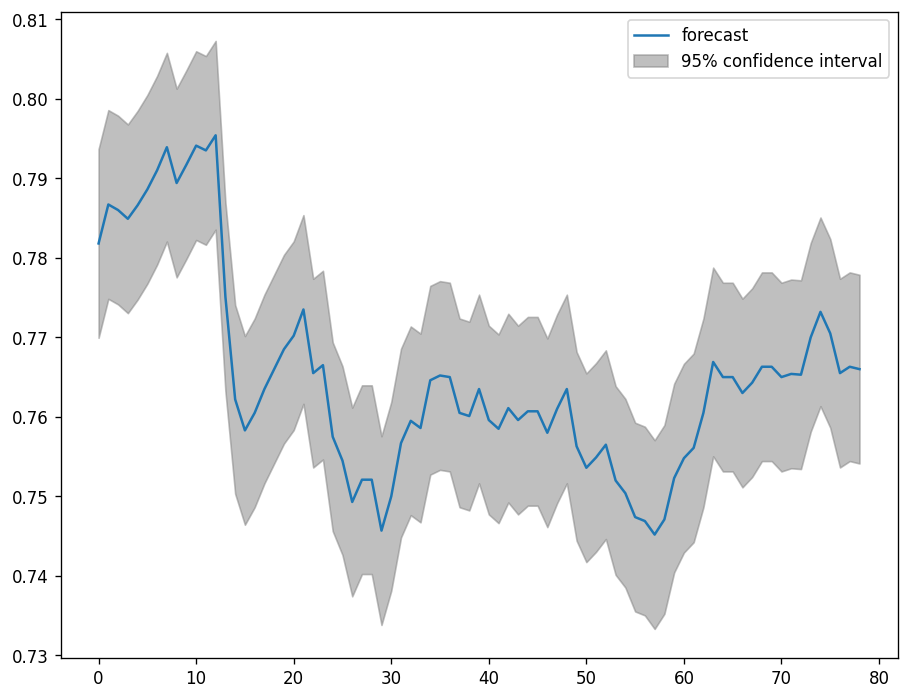

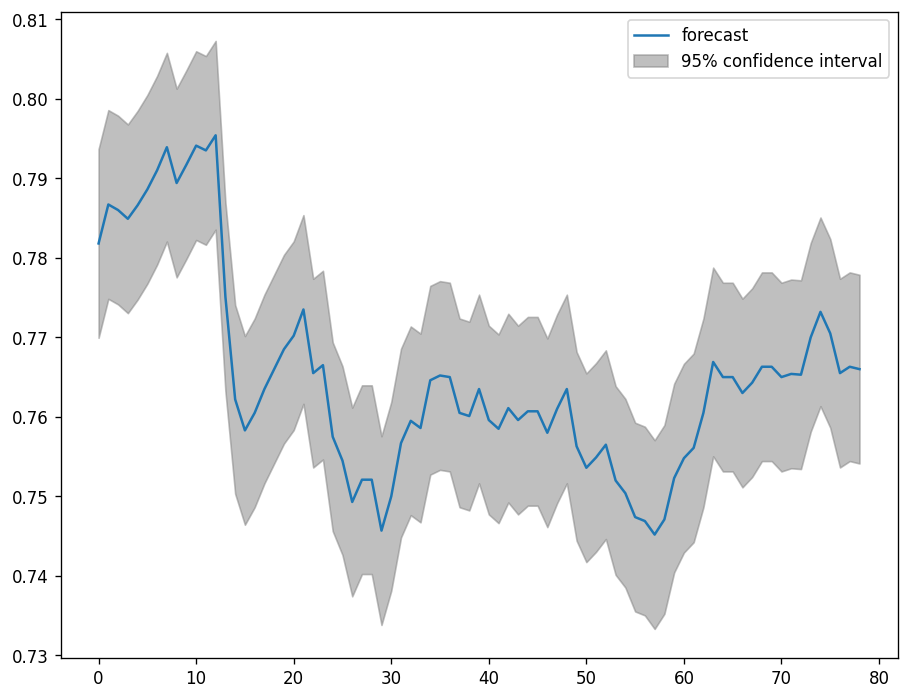

In [125]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
# fit model
model = ARIMA(X, order=(0,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)
plot_predict(model_fit ,start=1, end=79)


In [126]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
val_target = val[1]
forecast = forecast.astype('float')
rmse = sqrt(mean_squared_error(val_target, forecast))
print("RMSE:", rmse)

RMSE: 0.002280867464816118


From Plot: We observe that the model captures the trend very well, however, it looks like there is a downward shift in the predicted results.
From Performance Metrics: The error values are small (RMSE < 1), indicating that the model captured the trend in the dataset and is reliable.

### Model Building - Exponential Smoothing

In this technique,assign larger weights to more recent observations than to observations from the distant past.

In [127]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [90]:

series.index.freq = 'D'

In [91]:
series.index

RangeIndex(start=0, stop=7588, step=1)

In [86]:
# set the span and the smoothing factor alpha
# span = 12
# alpha = 1/(span+1)

In [146]:
# Split into train and test set

train_size = int(len(series) * 0.50)
train_series = series.iloc[:-100, :]
test_series = series.iloc[-100:, :]

In [129]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7558 entries, 1990-01-01 to 2010-09-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7558 non-null   float64
dtypes: float64(1)
memory usage: 118.1 KB


### Double exponential smoothing

<Axes: title={'center': 'Holt Winters grapg: Additive Trend and Multiplicative Trend'}, xlabel='date'>

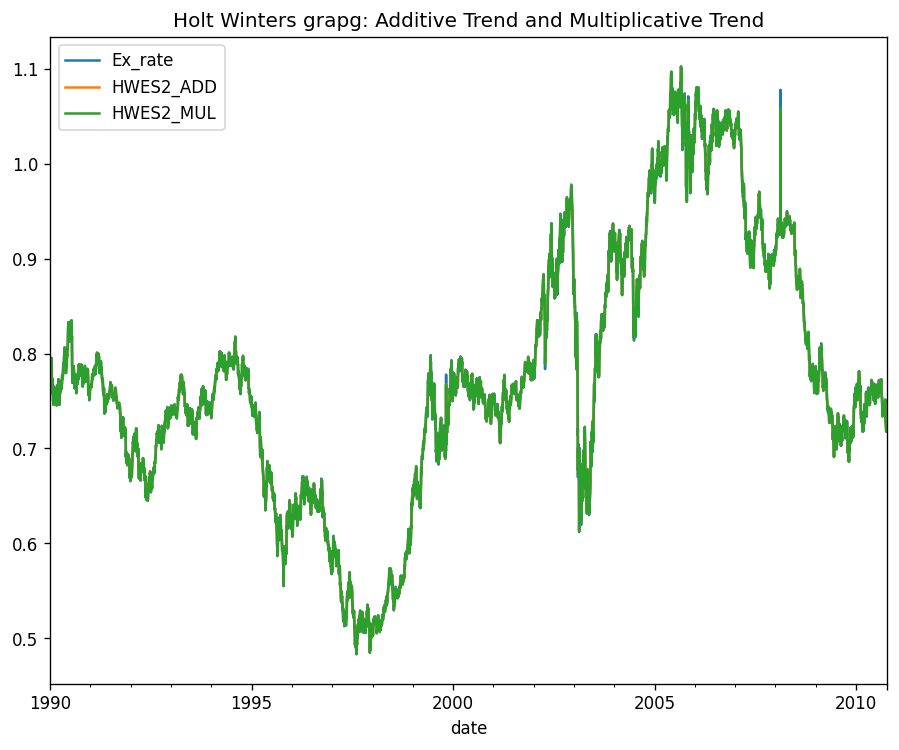

In [39]:
# Double exponential smoothing of visitors data set ( Additive and multiplicative)
series_df = series
series_df['HWES2_ADD'] = ExponentialSmoothing(series_df.Ex_rate,trend='add').fit().fittedvalues.shift(-1)
series_df['HWES2_MUL'] = ExponentialSmoothing(series_df.Ex_rate,trend='mul').fit().fittedvalues.shift(-1)
series_df.plot(title='Holt Winters grapg: Additive Trend and Multiplicative Trend')

In [133]:
test_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2010-08-22 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  50 non-null     float64
dtypes: float64(1)
memory usage: 800.0 bytes


In [41]:
model_mul = ExponentialSmoothing(train_series.Ex_rate,trend='add')
model_fit =  model_mul.fit()
pred_mul = model_fit.forecast(10)


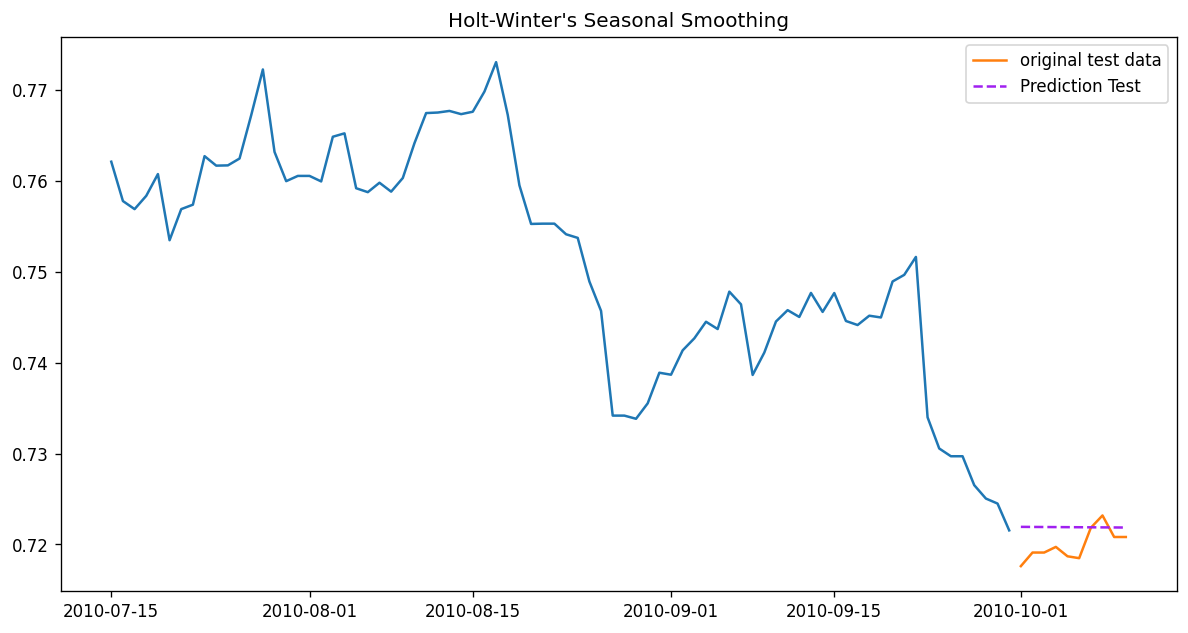

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(train_series.index[7500:], train_series.values[7500:]);
ax1.plot(test_series.index, test_series.values,label="original test data");
ax1.plot(test_series.index, pred_mul, linestyle='--', color='#A020F0', label="Prediction Test");
ax1.legend();
ax1.set_title("Holt-Winter's Seasonal Smoothing");

### Triple Exponential smoothing -Holt-Winter's

Hyperparameter Optimization using basinhopping

In [43]:
#find optimal value for parameters : smoothing level,trend and seasonal
model = ExponentialSmoothing(train_series.Ex_rate, missing='drop', trend='add', seasonal_periods=365,
                              seasonal='add',initialization_method="heuristic")
res = model.fit(optimized=True, method="basinhopping")

print(res.params['smoothing_level'])
print(res.params['smoothing_trend'])
print(res.params['smoothing_seasonal'])


0.8801538800879106
0.0
0.038311048531934636


Hyperparameter Optimization using Search method

In [176]:
alphas =  np.arange(0, 2, 0.20)
betas = [0]
gammas = np.arange(0.01, .2, 0.02)

In [177]:
print(alphas,betas,gammas)

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8] [0] [0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19]


In [147]:
from sklearn.metrics import mean_absolute_error
def tes_optimizer(train, test, abg, trend_mode='add', seasonal_mode = 'add', seasonal_period=365,step=100):
    """This function to optimize hyperparameters for the TES model

    Args:
        train (pd.Series): train dataset
        test (pd.Series): test dataset
        abg (list): a tuple list that holds tuple of alpha, beta, gamma values
        trend_mode (str, optional): 'add' || 'mul' . Is the trend additive or multiplying? Defaults to 'add'.
        seasonal_mode (str, optional): 'add' || 'mul' . Is the seasonality additive or multiplying?. Defaults to 'add'.
        seasonal_period (int, optional): Step number that evaluates for the seasonal period. Defaults to 12.
        step (int, optional): How many steps later will the model that created with the train dataset forecast?. Defaults to 48.

    Returns:
        [float, float, float, float]: best_alpha, best_beta, best_gamma, best_mae
    """
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg: # visit the each combination
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]) # 0: alpha, 1: beta, 2: gamma. Creates a new TES instance by using each combination
        y_pred = tes_model.forecast(step) # forecast the `step` step later by using the TES instance
        mae = mean_absolute_error(test, y_pred) # calculate the MAE (mean absolute error)
        if mae < best_mae: # mark the best parameters
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


In [178]:
comb_list = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_series,test_series, comb_list)

[0.0, 0, 0.01, 0.15]
[0.0, 0, 0.03, 0.15]
[0.0, 0, 0.05, 0.15]
[0.0, 0, 0.07, 0.15]
[0.0, 0, 0.09, 0.15]
[0.0, 0, 0.11, 0.15]
[0.0, 0, 0.13, 0.15]
[0.0, 0, 0.15, 0.15]
[0.0, 0, 0.17, 0.15]
[0.0, 0, 0.19, 0.15]
[0.2, 0, 0.01, 0.01]
[0.2, 0, 0.03, 0.01]
[0.2, 0, 0.05, 0.01]
[0.2, 0, 0.07, 0.01]
[0.2, 0, 0.09, 0.01]
[0.2, 0, 0.11, 0.01]
[0.2, 0, 0.13, 0.01]
[0.2, 0, 0.15, 0.01]
[0.2, 0, 0.17, 0.01]
[0.2, 0, 0.19, 0.01]
[0.4, 0, 0.01, 0.01]
[0.4, 0, 0.03, 0.01]
[0.4, 0, 0.05, 0.01]
[0.4, 0, 0.07, 0.01]
[0.4, 0, 0.09, 0.01]
[0.4, 0, 0.11, 0.01]
[0.4, 0, 0.13, 0.01]
[0.4, 0, 0.15, 0.01]
[0.4, 0, 0.17, 0.01]
[0.4, 0, 0.19, 0.01]
[0.6, 0, 0.01, 0.01]
[0.6, 0, 0.03, 0.01]
[0.6, 0, 0.05, 0.01]
[0.6, 0, 0.07, 0.01]
[0.6, 0, 0.09, 0.01]
[0.6, 0, 0.11, 0.02]
[0.6, 0, 0.13, 0.02]
[0.6, 0, 0.15, 0.02]
[0.6, 0, 0.17, 0.02]
[0.6, 0, 0.19, 0.02]
[0.8, 0, 0.01, 0.01]
[0.8, 0, 0.03, 0.01]
[0.8, 0, 0.05, 0.01]
[0.8, 0, 0.07, 0.01]
[0.8, 0, 0.09, 0.01]
[0.8, 0, 0.11, 0.01]
[0.8, 0, 0.13, 0.01]
[0.8, 0, 0.15

In [197]:
model = ExponentialSmoothing(train_series.Ex_rate,trend='add',seasonal='add',seasonal_periods=365,initialization_method="heuristic",missing='drop')
model2 = ExponentialSmoothing(train_series.Ex_rate, trend="add", seasonal="add", seasonal_periods=365, damped=True,initialization_method="heuristic",missing='drop')
model3 = model = ExponentialSmoothing(train_series.Ex_rate, missing='drop', trend='add', seasonal_periods=365,
                              seasonal='add',initialization_method="heuristic")

fit = model.fit(smoothing_level=best_alpha,
                                        smoothing_trend=best_beta, # beta
                                        smoothing_seasonal=best_gamma # gamma
                                        )
pred = fit.forecast(100)
fit2 = model2.fit(smoothing_level=0.8, # alpha
                                        smoothing_trend=0.0, # beta
                                        smoothing_seasonal=0.09 # gamma
                                        )
pred2 = fit2.forecast(100)

fit3 = model3.fit(smoothing_level=0.8, # alpha
                                        smoothing_trend=0.0, # beta
                                        smoothing_seasonal=0.038 # gamma
                                        )
pred3 = fit3.forecast(100)

sse1 = np.sqrt(np.mean(np.square(test_series.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test_series.values - pred2.values)))


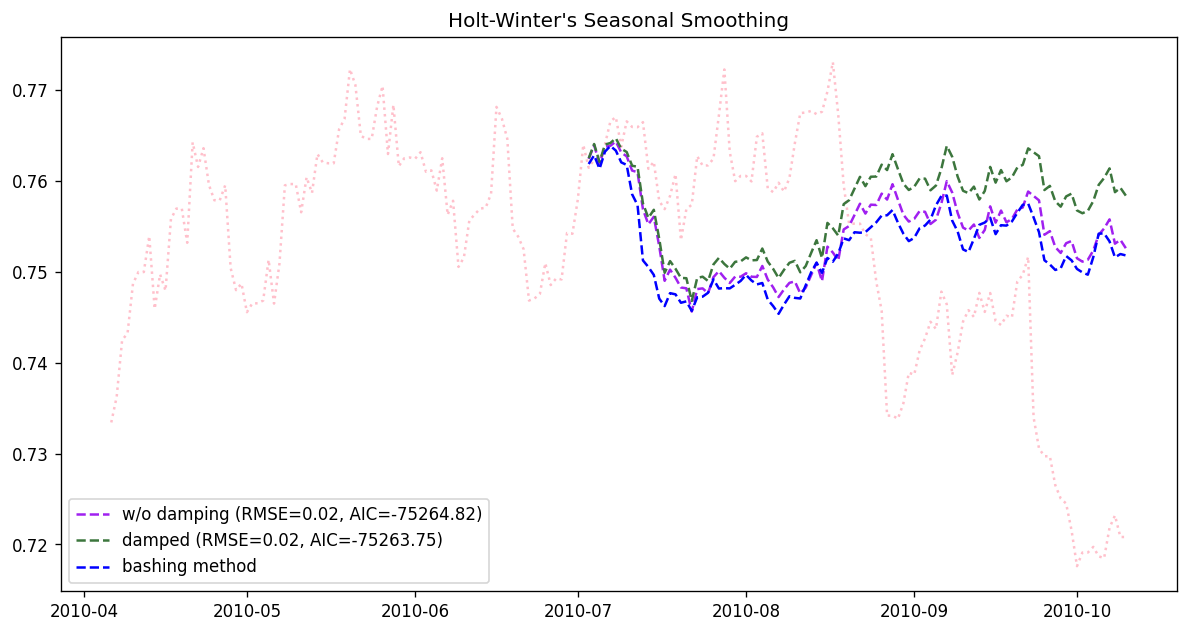

In [199]:
fig, ax = plt.subplots(figsize=(12, 6))
 # ax.plot(train_series.index[7400:], train_series.values[7400:]);
ax.plot(series.index[7400:],series.values[7400:],linestyle=':',color='pink')
 # ax.plot(test_series.index, test_series.values, label='test');
ax.plot(test_series.index, pred, linestyle='--', color='#A020F0', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test_series.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic));
ax.plot(test_series.index, pred3, linestyle='--', color='blue', label="bashing method");
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

From the plot it is visible damping is better.

### Model Fitting and Forecasting

In [215]:
tes_model = ExponentialSmoothing(series,
                                 trend="add", # add || mul
                                 seasonal="add", # add || mul
                                 seasonal_periods=365, # we set 12. It represents that 12 step (month for our case) equals a seasonal period
                                 damped=True,initialization_method="heuristic",missing='drop'
                                 ).fit(smoothing_level=0.8, # alpha
                                        smoothing_trend=0.0, # beta
                                        smoothing_seasonal=0.09 # gamma
                                        )

In [216]:
y_pred = tes_model.forecast(100)

In [208]:
def plot_co2(series, test, y_pred, title):
    """
        This function to visualize the act and predicted value of y
    """
    mae = mean_absolute_error(test, y_pred)
    # We use `train["2010":]` to narrow the scope of the visualization
    train["2010":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

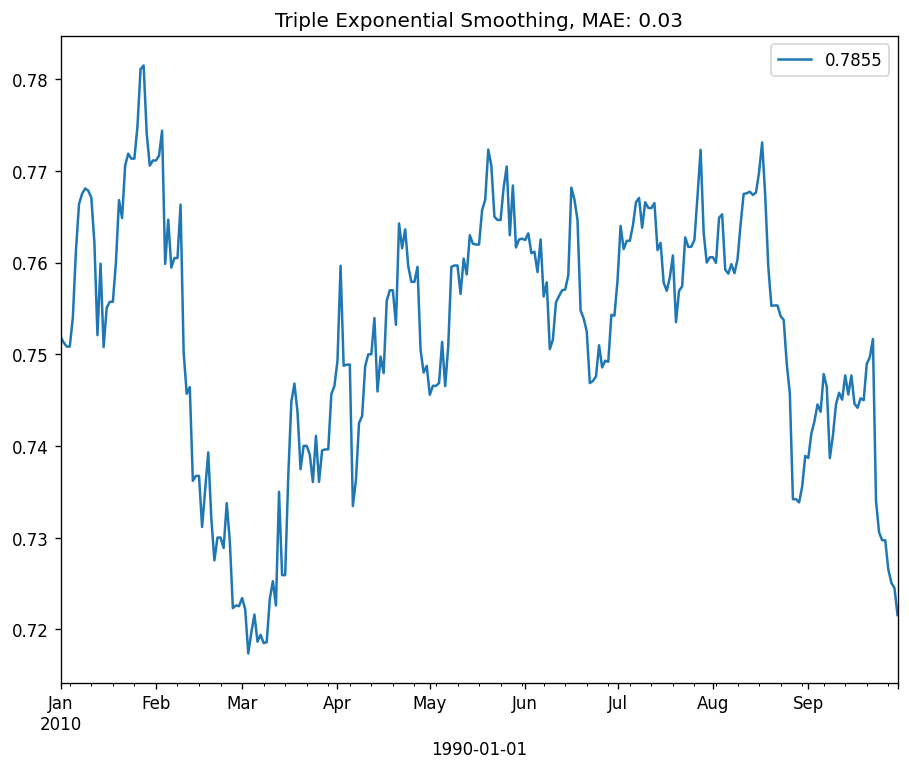

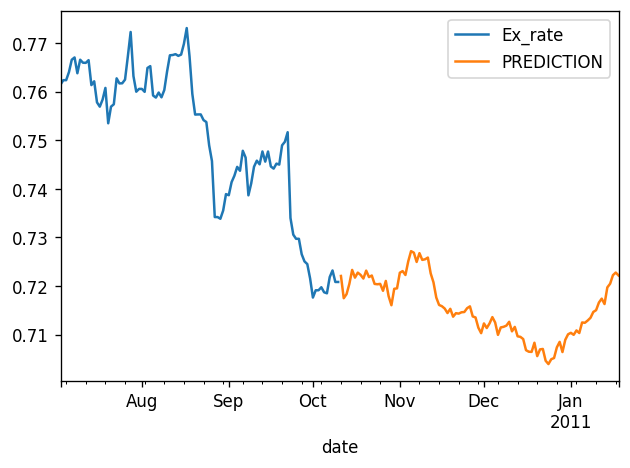

In [217]:
plot_co2(series, test_series, y_pred, "Triple Exponential Smoothing")

mae: 0.03, rmse is 0.02, RMSE is close to 0 indicates Model is a good one.


The ARIMA model has an RMSE of 0.0023, indicating a very low error rate.
The Holt-Winters model, on the other hand, has an RMSE of 0.02, which is slightly higher than the ARIMA model.
The ARIMA model's lower RMSE suggests that it is providing more accurate forecasts compared to the Holt-Winters model.
The higher RMSE of the Holt-Winters model may indicate that it is not capturing the underlying patterns in the data as effectively as the ARIMA model.